In [1]:
# 목적: 파이썬 코드를 활용하여 OpenAPI 호출 자동화
# Step1: OpenAPI를 제공하는 사이트에서 제공하는 샘플 프로그램을 확보한다.
import requests
import time
import json
import pandas as pd
import cx_Oracle
import threading

access_key= '4elzHyNYqS6rYhK7/UG4vA=='

"""
create table water_temperature(
    record_time varchar2(30),
    경포대해수욕장 number,
    대천해수욕장 number,
    해운대해수욕장 number,
    중문해수욕장 number
);
"""
# URL 호출
def get_request_url(day,observatory): # 현재 날짜와 관측소 코드 parameter로 받음
    url = 'http://www.khoa.go.kr/api/oceangrid/tidalBuTemp/search.do'
    response_list =[]
    for ob in observatory :
        params = {'ServiceKey': access_key,
        'ResultType': 'json','ObsCode': ob,'Date':day
        }
        response = requests.get(url, params=params)
        response_list.append(response.text)
    return response_list


def preprocessed_df_to_oracle(df):
    conn = cx_Oracle.connect('open_source/1111@192.168.0.32:1521/xe')
    cur = conn.cursor()
# 바인딩 변수 : SQL에 사용되는 동적인 데이터
# values(:바인딩 변수 1, :바인딩 변수2, ... , :바인딩 변수N)
    sql_insert = '''
    insert into
    water_temperature(record_time,경포대해수욕장,대천해수욕장,해운대해수욕장,중문해수욕장)
    values(:record_time,:경포대해수욕장,:대천해수욕장,:해운대해수욕장,:중문해수욕장 )
    '''

    # 특정행의 첫번째 값
    record_time = df.index[-1]
    경포대해수욕장 = df['경포대해수욕장'].iloc[-1]
    대천해수욕장 = df['대천해수욕장'].iloc[-1]
    해운대해수욕장 = df['해운대해수욕장'].iloc[-1]
    중문해수욕장 = df['중문해수욕장'].iloc[-1]

    cur.execute(sql_insert, (record_time,경포대해수욕장,대천해수욕장,해운대해수욕장,중문해수욕장))
    conn.commit()
    cur.close()
    conn.close()
def preprocess_df(parsed_json, obs_name):
    df1 = pd.DataFrame(parsed_json[0])
    df2 = pd.DataFrame(parsed_json[1])
    df3 = pd.DataFrame(parsed_json[2])
    df4 = pd.DataFrame(parsed_json[3])
    df1.set_index('record_time', inplace=True)
    df2.set_index('record_time', inplace=True)
    df3.set_index('record_time', inplace=True)
    df4.set_index('record_time', inplace=True)
    p_df = pd.concat([df1,df2,df3,df4], axis = 1)
    p_df.columns = obs_name
    return p_df
def water_temp_info_collector():
    day = time.strftime("%Y%m%d")
    observatory = ['TW_0089', 'TW_0069', 'TW_0062', 'TW_0075'] # 경포대/대천/중문/해운대
    raw_str_json = get_request_url(day, observatory)
    if raw_str_json:
        raw_json = []
        parsed_json = []
        obs_name = []
        for i in range(len(raw_str_json)):
            raw_json.append(json.loads(raw_str_json[i]))
            parsed_json.append(raw_json[i]['result']['data'])
            obs_name.append(raw_json[i]['result']['meta']['obs_post_name'])

    df = preprocess_df(parsed_json, obs_name)
    preprocessed_df_to_oracle(df)


def water_temp_info_scheduler():
    print('\n해양수온 수집기 스케줄러 동작\n')
    while True:
        water_temp_info_collector()
        print("수집완료 ")
        time.sleep(300) # 5분 주기로 데이터 수집

print('< 해양수온 데이터수집 스케줄러 ver1.0 >')

def print_main_menu():
    print('\n1. 해양수온 실시간 데이터 수집')
    print('2. 업데이트 예정')
    print('3. 스케줄러 종료')
    print('* 엔터: 메뉴 업데이트\n')
while True:
    print_main_menu()
    print('아래행에 메뉴입력: ', end='')
    selection = input()
    if selection == '':
        continue
    else:
        menu_num = int(selection)

    if(menu_num == 1):
        t = threading.Thread(target=water_temp_info_scheduler, daemon=True)
        t.start()
    elif(menu_num == 2):
        print('업데이트 예정중입니다.')
    elif(menu_num == 3):
        break
    elif (menu_num == 0):
        continue


< 해양수온 데이터수집 스케줄러 ver1.0 >

1. 해양수온 실시간 데이터 수집
2. 업데이트 예정
3. 스케줄러 종료
* 엔터: 메뉴 업데이트

아래행에 메뉴입력: 

KeyboardInterrupt: Interrupted by user

In [ ]:
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib import font_manager,rc
# 한글 폰트
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
def get_data_from_oracle():
    conn = cx_Oracle.connect('open_source/1111@192.168.0.32:1521/xe')
    query = "SELECT * FROM (SELECT * FROM water_temperature order by RECORD_TIME desc) WHERE ROWNUM <= 10 order by RECORD_TIME"
    df = pd.read_sql(query, con=conn)
    conn.close()
    return df





def plot_realtime_data():
    plt.ion()
    fig, ax = plt.subplots()

    while True:
        df = get_data_from_oracle()
        ax.clear()
        df.set_index('RECORD_TIME', inplace=True)
        for beach in df.columns:
            plt.plot(df.index, df[beach], label=beach)
        plt.xlabel('시간')
        plt.ylabel('온도(섭씨)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.draw()
        plt.pause(5)

plot_realtime_data()

C:\Users\1\AppData\Local\Temp\ipykernel_3128\2433513491.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


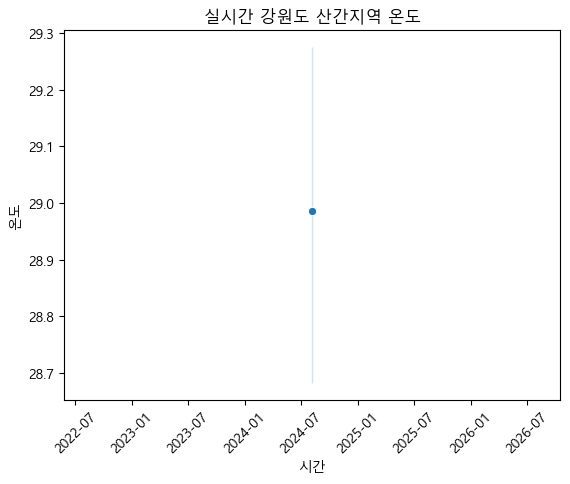

C:\Users\1\AppData\Local\Temp\ipykernel_3128\2433513491.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


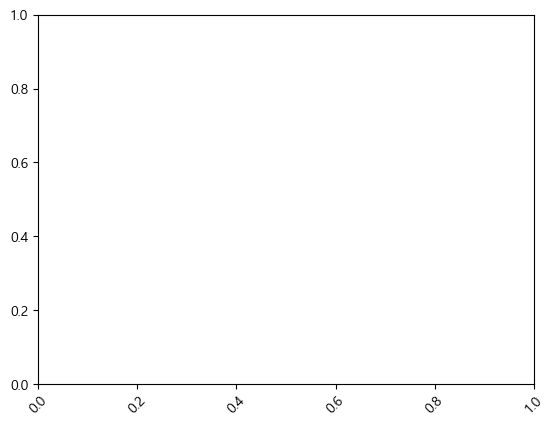

C:\Users\1\AppData\Local\Temp\ipykernel_3128\2433513491.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


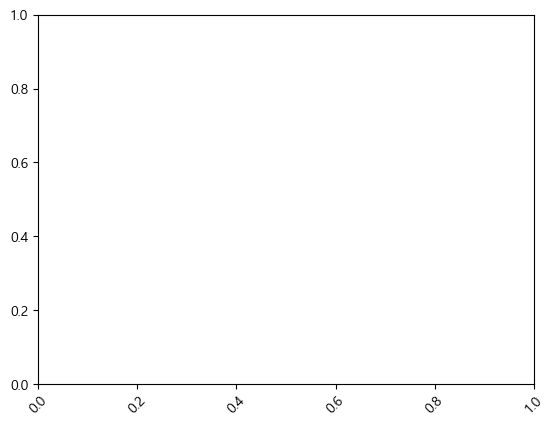

C:\Users\1\AppData\Local\Temp\ipykernel_3128\2433513491.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


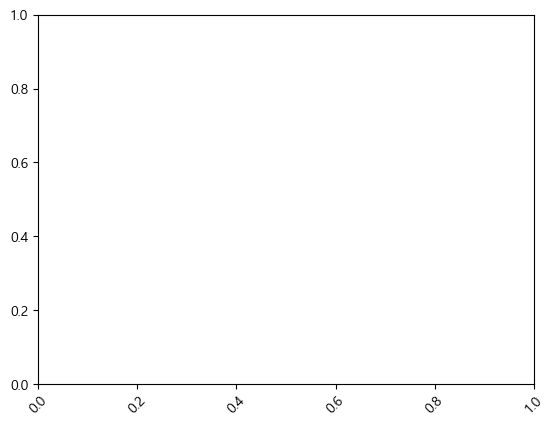

KeyboardInterrupt: 

In [7]:
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib import font_manager,rc
# 한글 폰트
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
def get_data_from_oracle():
    conn = cx_Oracle.connect('open_source/1111@192.168.0.37:1521/xe')
    query = "SELECT * FROM (SELECT * FROM weather ORDER BY DATE_TIME DESC)"
    df = pd.read_sql(query, con=conn)
    conn.close()
    return df

def plot_realtime_data():
    plt.ion()  # Interactive mode on
    fig, ax = plt.subplots()

    while True:
        df = get_data_from_oracle()
        ax.clear()
        sns.lineplot(x='DATE_TIME', y='기온', data=df, ax=ax, marker='o')
        ax.set(title='실시간 강원도 산간지역 온도', xlabel='시간', ylabel='온도')
        plt.xticks(rotation=45)
        plt.draw()
        plt.pause(5)
plot_realtime_data()

C:\Users\1\anaconda3\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


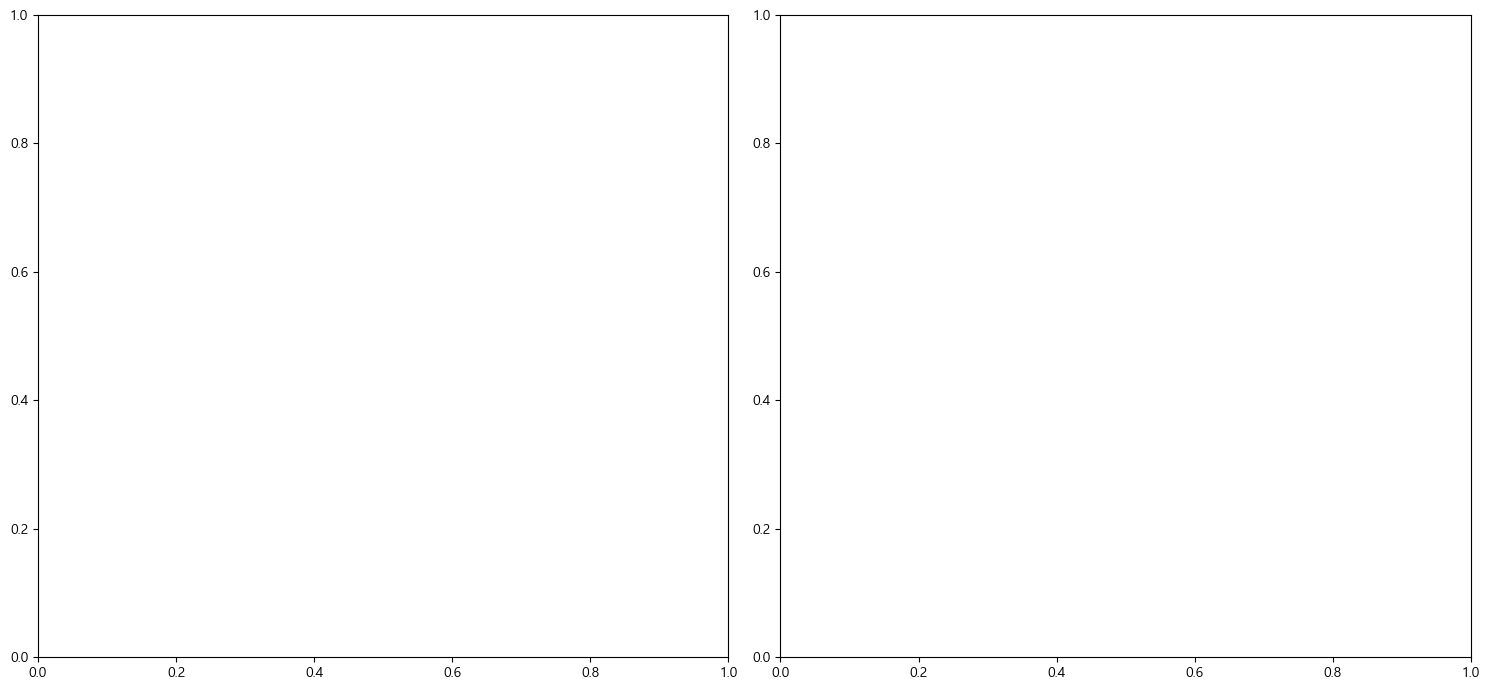

In [6]:
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import font_manager,rc
# 한글 폰트
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
def get_data_from_oracle():
    conn = cx_Oracle.connect('open_source/1111@192.168.0.37:1521/xe')
    query = "SELECT * FROM (SELECT * FROM weather ORDER BY DATE_TIME DESC)"
    df = pd.read_sql(query, con=conn)
    conn.close()
    return df

def update(frame):
    weather_data = get_data_from_oracle()

    # Clear previous data
    ax1.clear()
    ax2.clear()

    ax1.bar(weather_data['산이름'], weather_data['습도'], color=['blue', 'green', 'red', 'purple', 'orange'])
    ax1.set_xlabel('산이름')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel('습도')
    ax1.set_title('산별 습도')


    ax2.bar(weather_data['산이름'], weather_data['기온'], color=['blue', 'green', 'red', 'purple', 'orange'])
    ax2.set_xlabel('산이름')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylabel('기온')
    ax2.set_title('산별 기온')

# Setup plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Initialize the animation
ani = FuncAnimation(fig, update, interval=5000, cache_frame_data=False)  # Update every 5000 milliseconds (5 seconds)

plt.tight_layout()
plt.show()